/data/vinay_2421ma05/VINAY/BS_PF/.conda/bin/python
torch.Size([10000, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1])
torch.Size([10000, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1])


/tmp/ipykernel_2435231/434080092.py:50: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softplus(beta=1.0, threshold=20.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
No of Parameters 8577


  0%|          | 1/600 [00:00<04:32,  2.19it/s]

0/600 PDE Loss: 0.003971994, BVP Loss: 0.040842451, IC Loss: 0.015423167,


 19%|█▉        | 113/600 [00:10<00:07, 61.58it/s]

100/600 PDE Loss: 0.000089838, BVP Loss: 0.000317552, IC Loss: 0.000032730,


 35%|███▌      | 211/600 [00:12<00:06, 63.58it/s]

200/600 PDE Loss: 0.000089838, BVP Loss: 0.000317552, IC Loss: 0.000032730,


 52%|█████▏    | 309/600 [00:13<00:04, 62.08it/s]

300/600 PDE Loss: 0.000089838, BVP Loss: 0.000317552, IC Loss: 0.000032730,


 68%|██████▊   | 407/600 [00:15<00:03, 63.73it/s]

400/600 PDE Loss: 0.000089838, BVP Loss: 0.000317552, IC Loss: 0.000032730,


 85%|████████▌ | 512/600 [00:16<00:01, 63.75it/s]

500/600 PDE Loss: 0.000089838, BVP Loss: 0.000317552, IC Loss: 0.000032730,


100%|██████████| 600/600 [00:18<00:00, 33.16it/s]


Loss Res:  0.000090, Loss_BC:  0.000318, Loss_IC:  0.000033
Train Loss: 0.000440


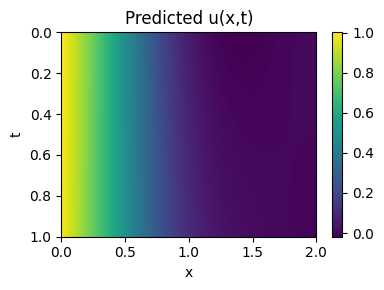

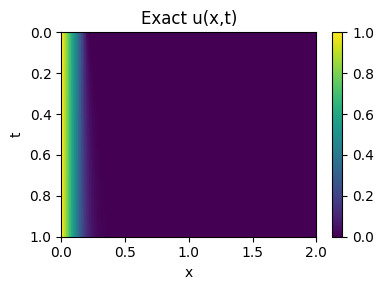

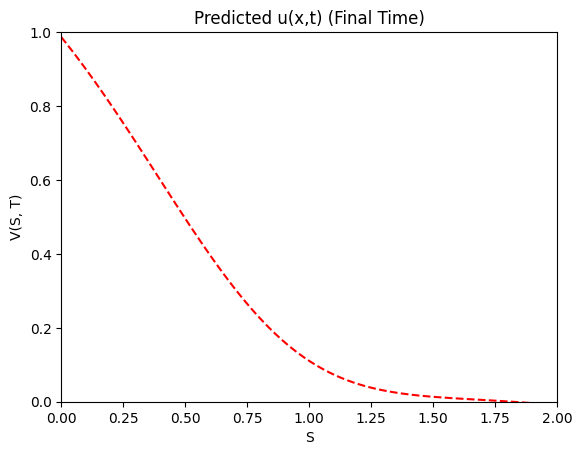

In [3]:
import sys
from zmq import device
print(sys.executable)
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
from scipy.stats import norm
from utils import *
from pinn import PINNs
# BS params
#K = 4
#sigma = 0.3
#r = 0.03
#T = 1
#L = 10
#N_x = 101
#N_t = 101
K=1
sigma=0.3
r=0.01
T=1
L=2
beta=1   # OR beta=3
N_x = 101
N_t = 101
seed = 0
torch.cuda.manual_seed(seed)
device = torch.device("cuda:1")
res, b_left, b_right, b_upper, b_lower = get_data([0,2], [0, 1], N_x, N_t)
# res_test, _, _, _, _ = get_data([0,10], [0,1], N_x, N_t)
# print(res.shape, b_left.shape, b_right.shape, b_upper.shape, b_lower.shape)
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)
x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]
print(x_res.shape, x_left.shape, x_right.shape, x_upper.shape, x_lower.shape)
print(t_res.shape, t_left.shape, t_right.shape, t_upper.shape, t_lower.shape)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
pinn = PINNs(in_dim=2, hidden_dim=64, out_dim=1, num_layer=4).to(device)
pinn.apply(init_weights)
optim = LBFGS(pinn.parameters(), line_search_fn='strong_wolfe')
#optim = Adam(pinn.parameters(), lr=1e-4)
n_params = get_n_params(pinn)
print(pinn)
print('No of Parameters',n_params)
loss_track = []
n_epochs = 600
for i in tqdm(range(n_epochs)):
  def closure():
    pred_res = pinn(x_res, t_res)
    pred_left = pinn(x_left, t_left)
    pred_right = pinn(x_right, t_right)
    pred_upper = pinn(x_upper, t_upper)
    pred_lower = pinn(x_lower, t_lower)
    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    loss_res = torch.mean((u_t - ((sigma**2 * x_res**beta) / 2) * u_xx - (r * x_res) * u_x + (r * pred_res)) ** 2)
    loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower - (K * torch.exp(-r * t_lower))) ** 2)
    loss_ic = torch.mean((pred_left[:,0] - torch.max(K - x_left[:,0], torch.zeros(x_left[:,0].shape).to(device))) ** 2)
    loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
    loss = loss_res + loss_ic + loss_bc
    optim.zero_grad()
    loss.backward()
    return loss
  optim.step(closure)
  if i % 100 == 0:
        print(f'{i}/{n_epochs} PDE Loss: {loss_track[-1][0]:.9f}, BVP Loss: {loss_track[-1][1]:.9f}, IC Loss: {loss_track[-1][2]:.9f},')

print('Loss Res: {:9f}, Loss_BC: {:9f}, Loss_IC: {:9f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

state = {
    'epoch': n_epochs,
    'state_dict': pinn.state_dict(),
    'optimizer': optim.state_dict(),
    'loss_hist': loss_track
}
torch.save(state, './BS_Put_PINNs_101')

# Testing
N_x=101
N_t=101
res_test, _, b_right_test, _, _ = get_test_data([0,L], [0,1], N_x, N_t)
N = norm.cdf
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
b_right_test = torch.tensor(b_right_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]
x_right_test, t_right_test = b_right_test[:,0:1], b_right_test[:,1:2]
x_test.requires_grad_()
t_test.requires_grad_()

#with torch.no_grad():
pred = pinn(x_test, t_test)[:,0:1]
pred_right = pinn(x_right_test, t_right_test)[:,0:1]
    #pred = pred.cpu().detach().numpy()
pred_right = pred_right.cpu().detach().numpy()
#pred = pred.reshape(N_x,N_t)
# print(pred_right.shape)

delta=torch.autograd.grad(pred, x_test, grad_outputs=torch.ones_like(pred), retain_graph=True, create_graph=True)[0]
gamma=torch.autograd.grad(delta,x_test,grad_outputs=torch.ones_like(delta), retain_graph=True, create_graph=True)[0]
theta=torch.autograd.grad(pred,t_test,grad_outputs=torch.ones_like(pred), retain_graph=True, create_graph=True)[0]


#convert prediction to numpy for plotting
pred_np = pred.cpu().detach().numpy()
pred_np = pred_np.reshape(N_x, N_t)
def BS_CALL(S, T):
    d1 = (torch.log(S/K) + (r + sigma**2 / 2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)
    return S * N(d1) - K * torch.exp(-r*T)* N(d2)

def BS_PUT(S, T):
    d1 = (np.log(np.where(S/K > 1e-8, S/K, 1e-8)) + (r + sigma**2/2)*T) / (sigma*np.sqrt(np.where(T > 1e-8, T, 1e-8)))
    d2 = d1 - sigma* np.sqrt(T)
    return K * np.exp(-r*T) * (1 - N(d2)) + S * (N(d1) - 1)

res_test, _, b_right_test, _, _ = get_test_data([0,10], [0,1], N_x, N_t)
u = BS_PUT(res_test[:,0], res_test[:,1]).reshape(N_x,N_t)
u_right = BS_PUT(b_right_test[:,0], b_right_test[:,1])


plt.figure(figsize=(4,3))
plt.imshow(pred_np, extent=[0,L,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dBS_Put_pinns_pred.png')

plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,L,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dBS_Put_exact.png')

# plt.plot(X[final_index, 0], y_pred[final_index], '--', color="r")
plt.figure()
plt.plot(x_right_test.cpu().detach().numpy(), pred_right, '--', color="r")
plt.xlabel('S')
plt.ylabel('V(S, T)')
plt.title('Predicted u(x,t) (Final Time)')
# set the limits
plt.xlim([0, L])
plt.ylim([0, 1])
plt.savefig('./1dBS_Put_pinns_pred(Final Time).png')
plt.show()


In [ ]:
# Computing Dupires Equations 
K = torch.tensor([[1.0]], requires_grad=True).to(pred.device)  # match device
pred_K=torch.autograd.grad(pred,K, grad_outputs=torch.ones_like(pred), retain_graph=True, create_graph=True)[0] 
pred_KK=torch.autograd.grad(pred_K, grad_outputs=torch.ones_like(pred), retain_graph=True, create_graph=True)[0]
Vol_CEV_surface=2* (theta+r*K*pred_K)/K**2*pred_KK
print(Vol_CEV_surface)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [4]:

# Step 1: Convert to NumPy
delta_np = delta.cpu().detach().numpy().reshape(N_x, N_t)
gamma_np = gamma.cpu().detach().numpy().reshape(N_x, N_t)
theta_np= theta.cpu().detach().numpy().reshape(N_x, N_t)
t_np = t_test.cpu().detach().numpy().reshape(N_x, N_t)
moneyness = (x_test / K).cpu().detach().numpy().reshape(N_x, N_t)


def plot_surf(t_grid, moneyness_grid, Z, zlabel, title, filename):
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    # Now t is x-axis, moneyness is y-axis
    ax.plot_surface(t_grid, moneyness_grid, Z, cmap='Blues', edgecolor='k', linewidth=0.3)
    
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Moneyness (S/K)')
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    

    ax.view_init(elev=25, azim=45)
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()


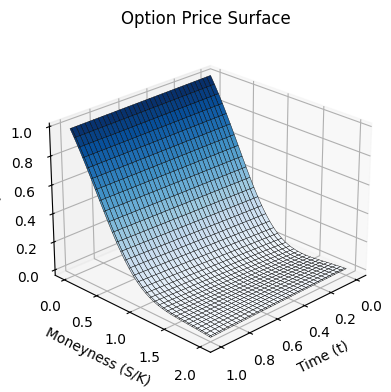

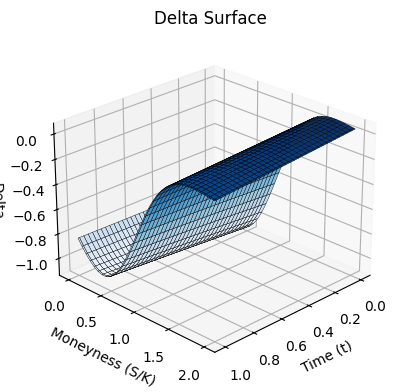

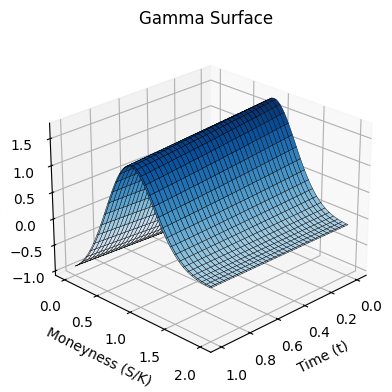

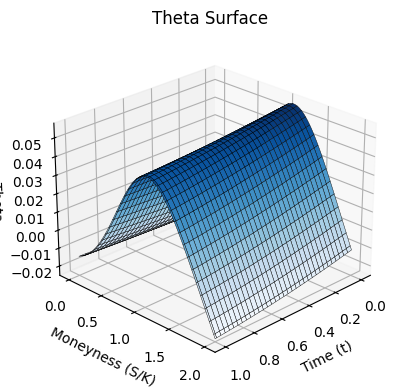

In [5]:
plot_surf(t_np, moneyness, pred_np, 'Price', 'Option Price Surface', './price_surface.png')
plot_surf(t_np, moneyness, delta_np, 'Delta', 'Delta Surface', './delta_surface.png')
plot_surf(t_np, moneyness, gamma_np, 'Gamma', 'Gamma Surface', './gamma_surface.png')
plot_surf(t_np, moneyness, theta_np, 'Theta', 'Theta Surface', './theta_surface.png')
